In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm

In [2]:
df = pd.read_csv("LamaH-CE/raw/D_gauges/2_timeseries/hourly/ID_399.csv", sep=";")
df.iloc[0]

YYYY    1999
MM        10
DD         7
hh         0
mm         0
qobs    2035
ckhs       1
qceq       0
qcol       0
Name: 0, dtype: int64

In [3]:
def process(years):
    stream_dist = pd.read_csv("LamaH-CE/raw/B_basins_intermediate_all/1_attributes/Stream_dist.csv", sep=";")
    stream_dist.drop(columns="strm_slope", inplace=True)  # will re-calculate from dist_hdn and elev_diff

    def collect_upstream(id):
        predecessors = set(stream_dist[stream_dist["NEXTDOWNID"] == id]["ID"])
        if len(predecessors) == 0:
            return {id}
        else:
            return {id}.union(*(collect_upstream(pred) for pred in predecessors))

    connected_gauges = set(stream_dist["ID"]).union(stream_dist["NEXTDOWNID"])
    danube_gauges = set(collect_upstream(399))  # 399 is most downstream Danube gauge
    assert danube_gauges.issubset(connected_gauges)

    feasible_gauges = set()
    qobs_statistics = pd.DataFrame(columns=["mean", "std", "min", "median", "max"], index=pd.Index([], name="ID"))
    for gauge_id in danube_gauges:
        ts = pd.read_csv(f"LamaH-CE/raw/D_gauges/2_timeseries/hourly/ID_{gauge_id}.csv",
                         sep=";", usecols=["YYYY", "MM", "DD", "hh", "mm", "qobs"])
        if (ts["qobs"] >= 0).all():
            sub_ts = ts[(ts["YYYY"] >= min(years)) & (ts["YYYY"] <= max(years))]
            expected_num_hrs = sum(24 * (365 + int(year % 4 == 0)) for year in years)
            if len(sub_ts) == expected_num_hrs:
                feasible_gauges.add(gauge_id)
                qobs_statistics.loc[gauge_id] = [ts["qobs"].mean(), ts["qobs"].std(),
                                                 ts["qobs"].min(), ts["qobs"].median(), ts["qobs"].max()]
                assert tuple(sub_ts.iloc[0, :5]) == (min(years), 1, 1, 0, 0) \
                       and tuple(sub_ts.iloc[-1, :5]) == (max(years), 12, 31, 23, 0)
    return len(feasible_gauges)

In [4]:
start_years = range(2000, 2018)
num_gauges = [process(range(start_year, 2018)) for start_year in tqdm(start_years)]

100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [14:39<00:00, 48.85s/it]


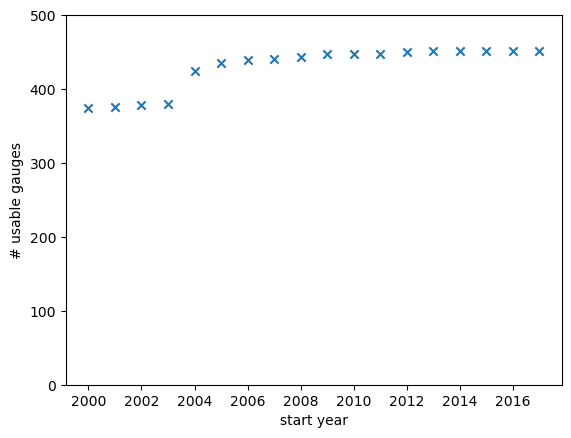

In [5]:
plt.scatter(start_years, num_gauges, marker="x")
plt.xticks(range(2000, 2018, 2))
plt.ylim(0, 500)
plt.xlabel("start year")
plt.ylabel("# usable gauges")
plt.savefig("start_year_tradeoff.png")
plt.show()

In [6]:
print("min:", min(num_gauges))
print("max:", max(num_gauges))

min: 375
max: 451
